In [137]:
import math
import matplotlib
import numpy as np
import pandas as pd
import xgboost
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tqdm import tqdm_notebook



%matplotlib inline

stk_path = "C:/Users/Parikshit Ghosh/Downloads/ML models/CLX.csv"
test_size = 0.2                
cv_size = 0.2                 
N = 3                         

n_estimators = 100            
max_depth = 3                  
learning_rate = 0.1            
min_child_weight = 1           
subsample = 1                 
colsample_bytree = 1           
colsample_bylevel = 1          
gamma = 0                      

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [138]:
def get_mov_avg_std(df, col, N):
 
    mean_list = df[col].rolling(window = N, min_periods=1).mean()
    std_list = df[col].rolling(window = N, min_periods=1).std() 
    

    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    

    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):


    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    
 

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    
    model.fit(X_train_scaled, y_train_scaled)
    
    
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [139]:
df = pd.read_csv(stk_path, sep = ",")


df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]


df['month'] = df['date'].dt.month


df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2011-06-13,66.760002,67.059998,66.449997,66.760002,50.512547,703400,6
1,2011-06-14,67.110001,67.370003,66.930000,67.040001,50.724415,919700,6
2,2011-06-15,66.629997,66.980003,65.970001,66.300003,50.164494,948200,6
3,2011-06-16,66.089996,66.910004,66.089996,66.809998,50.550377,871700,6
4,2011-06-17,66.940002,67.980003,66.839996,67.540001,51.102718,1602300,6


Text(0, 0.5, 'USD')

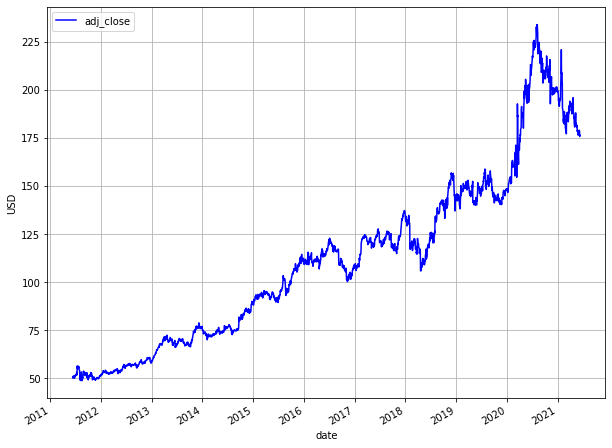

In [140]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [141]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2011-06-13,50.512547,703400,6,0.610001,0.000000
1,2011-06-14,50.724415,919700,6,0.440003,0.070000
2,2011-06-15,50.164494,948200,6,1.010002,0.329994
3,2011-06-16,50.550377,871700,6,0.820008,-0.720002
4,2011-06-17,51.102718,1602300,6,1.140007,-0.599999


In [142]:
df['order_day'] = [x for x in list(range(len(df)))]

merging_keys = ['order_day']


lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [143]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

df = df[N:]
    
df.head()

<ipython-input-143-8d3c577bf558>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/3 [00:00<?, ?it/s]

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2011-06-16,50.550377,871700,6,0.820008,-0.720002,3,50.164494,1.010002,0.329994,948200.0,50.724415,0.440003,0.070000,919700.0,50.512547,0.610001,0.000000,703400.0
4,2011-06-17,51.102718,1602300,6,1.140007,-0.599999,4,50.550377,0.820008,-0.720002,871700.0,50.164494,1.010002,0.329994,948200.0,50.724415,0.440003,0.070000,919700.0
5,2011-06-20,51.344837,664100,6,0.720001,-0.360001,5,51.102718,1.140007,-0.599999,1602300.0,50.550377,0.820008,-0.720002,871700.0,50.164494,1.010002,0.329994,948200.0
6,2011-06-21,51.284313,620300,6,0.500000,0.440002,6,51.344837,0.720001,-0.360001,664100.0,51.102718,1.140007,-0.599999,1602300.0,50.550377,0.820008,-0.720002,871700.0
7,2011-06-22,51.019489,480400,6,0.690002,0.339997,7,51.284313,0.500000,0.440002,620300.0,51.344837,0.720001,-0.360001,664100.0,51.102718,1.140007,-0.599999,1602300.0


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2513 entries, 3 to 2515
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2513 non-null   datetime64[ns]
 1   adj_close        2513 non-null   float64       
 2   volume           2513 non-null   int64         
 3   month            2513 non-null   int64         
 4   range_hl         2513 non-null   float64       
 5   range_oc         2513 non-null   float64       
 6   order_day        2513 non-null   int64         
 7   adj_close_lag_1  2513 non-null   float64       
 8   range_hl_lag_1   2513 non-null   float64       
 9   range_oc_lag_1   2513 non-null   float64       
 10  volume_lag_1     2513 non-null   float64       
 11  adj_close_lag_2  2513 non-null   float64       
 12  range_hl_lag_2   2513 non-null   float64       
 13  range_oc_lag_2   2513 non-null   float64       
 14  volume_lag_2     2513 non-null   float64

In [145]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [146]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

In [147]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2011-06-16,50.550377,871700,6,0.820008,-0.720002,3,50.164494,1.010002,0.329994,...,0.000000,703400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-06-17,51.102718,1602300,6,1.140007,-0.599999,4,50.550377,0.820008,-0.720002,...,0.070000,919700.0,50.550377,NaN,0.820008,NaN,-0.720002,NaN,8.717000e+05,NaN
5,2011-06-20,51.344837,664100,6,0.720001,-0.360001,5,51.102718,1.140007,-0.599999,...,0.329994,948200.0,50.826548,0.390564,0.980007,0.226273,-0.660000,0.084855,1.237000e+06,516612.214335
6,2011-06-21,51.284313,620300,6,0.500000,0.440002,6,51.344837,0.720001,-0.360001,...,-0.720002,871700.0,50.999311,0.407200,0.893339,0.219395,-0.560001,0.183303,1.046033e+06,492797.010272
7,2011-06-22,51.019489,480400,6,0.690002,0.339997,7,51.284313,0.500000,0.440002,...,-0.599999,1602300.0,51.243956,0.126004,0.786669,0.325170,-0.173333,0.544550,9.622333e+05,554746.440577


In [148]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1509
num_cv = 502
num_test = 502
train.shape = (1509, 27)
cv.shape = (502, 27)
train_cv.shape = (2011, 27)
test.shape = (502, 27)


In [149]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 8.22550344e+01  8.22048643e+01  1.28379721e+00 -3.97482399e-02
  1.04126090e+06  8.21560426e+01  1.28318754e+00 -3.94632823e-02
  1.04158522e+06  8.21072544e+01  1.28266401e+00 -3.95162989e-02
  1.04171445e+06]
scaler.var_ = [5.41424148e+02 5.40843388e+02 5.19988623e-01 7.43668687e-01
 5.46322268e+11 5.40318073e+02 5.20456231e-01 7.43608621e-01
 5.46084590e+11 5.39811496e+02 5.20747231e-01 7.43600192e-01
 5.45971971e+11]
train_scaled.shape = (1509, 13)
train_scaled.shape = (1509, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.362556,-1.377723,-0.379690,0.428755,-0.125905,-1.352204,-1.168774,0.126939,-0.164938,-1.359857,-0.932146,0.045825,-0.457863,2011-06-16,6
1,-1.338818,-1.361130,-0.643167,-0.788826,-0.229404,-1.376292,-0.378674,0.428442,-0.126371,-1.350738,-1.167722,0.127002,-0.165130,2011-06-17,6
2,-1.328413,-1.337379,-0.199403,-0.649670,0.759047,-1.359691,-0.642033,-0.789188,-0.229893,-1.374838,-0.377843,0.428506,-0.126559,2011-06-20,6
3,-1.331014,-1.326968,-0.781853,-0.371367,-0.510273,-1.335929,-0.198469,-0.650027,0.758773,-1.358229,-0.641128,-0.789131,-0.230092,2011-06-21,6
4,-1.342395,-1.329571,-1.086943,0.556321,-0.569531,-1.325513,-0.780657,-0.371712,-0.510822,-1.334456,-0.197688,-0.649969,0.758677,2011-06-22,6


In [150]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 9.45550932e+01  9.45060194e+01  1.57396315e+00 -4.97166544e-02
  1.04077777e+06  9.44567779e+01  1.57351064e+00 -4.95923416e-02
  1.04086121e+06  9.44078059e+01  1.57304321e+00 -4.96370935e-02
  1.04082491e+06]
scaler_train_cv.var_ = [9.03441353e+02 9.02952803e+02 1.00877692e+00 1.24487284e+00
 4.82150006e+11 9.02385999e+02 1.00939119e+00 1.24487151e+00
 4.82115792e+11 9.01864784e+02 1.00985234e+00 1.24486304e+00
 4.82137640e+11]
train_cv_scaled.shape = (2011, 13)
train_cv_scaled.shape = (2011, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.464028,-1.475632,-0.561502,0.340322,-0.133326,-1.455817,-1.128222,0.107187,-0.174497,-1.461662,-0.958333,0.044488,-0.485950,2011-06-16,6
1,-1.445651,-1.462790,-0.750668,-0.600755,-0.243498,-1.474456,-0.560881,0.340211,-0.133451,-1.454607,-1.127500,0.107227,-0.174441,2011-06-17,6
2,-1.437596,-1.444409,-0.432064,-0.493200,0.808678,-1.461611,-0.749989,-0.600867,-0.243627,-1.473252,-0.560288,0.340252,-0.133396,2011-06-20,6
3,-1.439610,-1.436352,-0.850239,-0.278098,-0.542474,-1.443224,-0.431482,-0.493312,0.808587,-1.460402,-0.749353,-0.600828,-0.243569,2011-06-21,6
4,-1.448420,-1.438366,-1.069281,0.438919,-0.605553,-1.435164,-0.849530,-0.278209,-0.542613,-1.442010,-0.430919,-0.493273,0.808621,2011-06-22,6


In [151]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

<ipython-input-151-7c20de4c3c09>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1512,2017-06-15,1.143310,-0.431544,-0.711766,1.152146,-0.642557,-0.509588,-1.101377,0.250313,0.851065,1.115716,-0.815508,-0.300207
1513,2017-06-16,0.920715,0.143144,-1.063858,0.728202,0.411973,-1.140175,-0.577350,-0.577350,1.154701,0.849103,0.253141,-1.102245
1514,2017-06-19,-0.169620,1.073962,-0.904342,1.140175,-0.411973,-0.728202,1.154701,-0.577350,-0.577350,1.073167,-0.167485,-0.905682
1515,2017-06-20,1.059604,-0.927206,-0.132398,-0.241489,1.098631,-0.857142,-0.649727,1.151538,-0.501811,-1.007948,0.991858,0.016090
1516,2017-06-21,-0.163982,1.071856,-0.907874,-0.950807,-0.092024,1.042831,0.699525,-1.145375,0.445849,-0.611452,-0.542563,1.154015


In [152]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

<ipython-input-152-3606b466347d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2014,2019-06-14,-0.719455,1.141897,-0.422442,1.149393,-0.670470,-0.478922,1.140460,-0.726795,-0.413666,1.151169,-0.653740,-0.497429
2015,2019-06-17,0.539279,-1.153881,0.614603,-0.090948,1.042368,-0.951419,-0.789057,1.124625,-0.335568,-0.721899,1.141428,-0.419529
2016,2019-06-18,-1.039317,0.955394,0.083923,0.424748,-1.142262,0.717514,0.857264,-1.098575,0.241311,-0.302009,-0.814186,1.116195
2017,2019-06-19,-0.898492,-0.178874,1.077366,0.558013,0.596474,-1.154487,0.335522,0.789092,-1.124615,0.342492,0.783753,-1.126246
2018,2019-06-20,-0.863146,-0.232681,1.095828,-1.154563,0.561828,0.592735,-1.087071,0.206329,0.880742,1.087565,-0.879791,-0.207774


In [153]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1509, 12)
y_train.shape = (1509,)
X_cv.shape = (502, 12)
y_cv.shape = (502,)
X_train_cv.shape = (2011, 12)
y_train_cv.shape = (2011,)
X_sample.shape = (502, 12)
y_sample.shape = (502,)


In [154]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1509, 12)
y_train_scaled.shape = (1509,)
X_cv_scaled.shape = (502, 12)
X_train_cv_scaled.shape = (2011, 12)
y_train_cv_scaled.shape = (2011,)
X_sample_scaled.shape = (502, 12)


Text(0.5, 1.0, 'Without scaling')

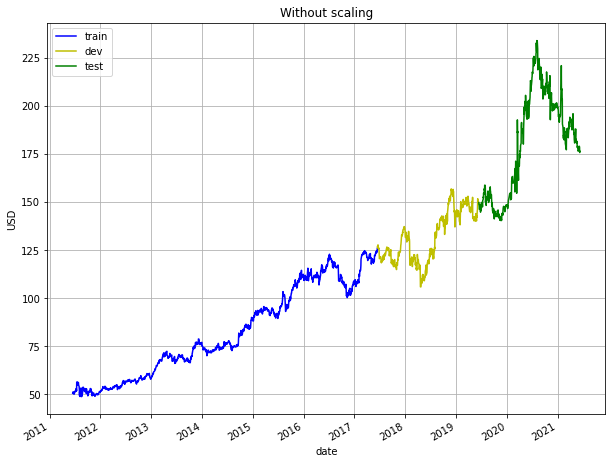

In [155]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

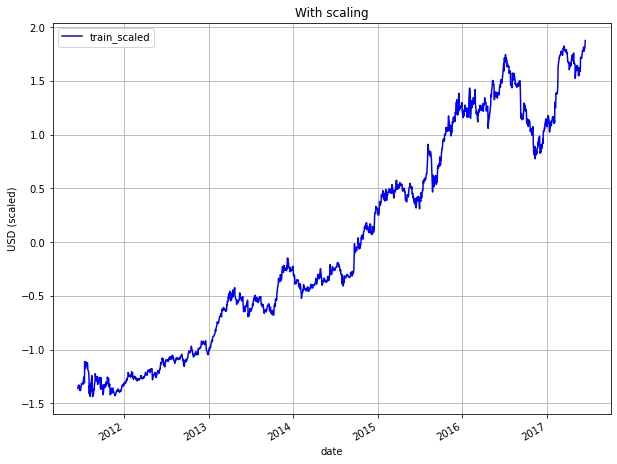

In [156]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [157]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [158]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.642
MAPE on train set = 0.554%


Text(0.5, 1.0, 'Without scaling')

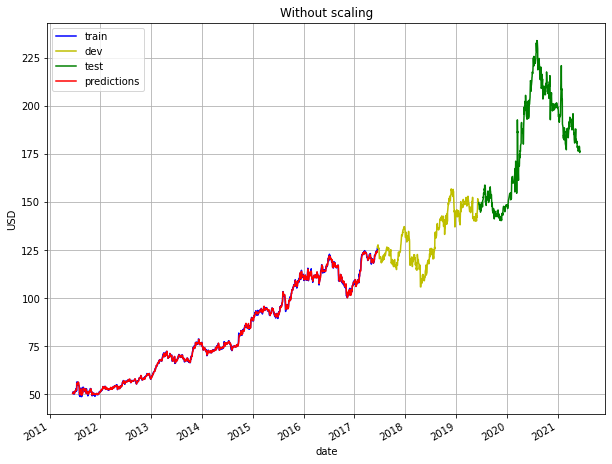

In [159]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [160]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 1.835
MAPE on dev set = 0.976%


<ipython-input-160-2191fa052402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
<ipython-input-160-2191fa052402>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


Text(0, 0.5, 'USD')

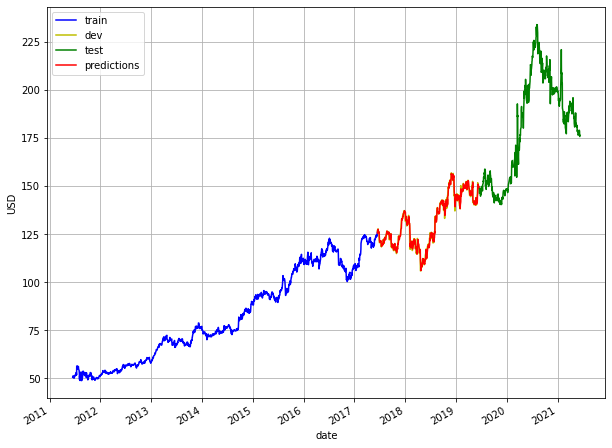

In [161]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

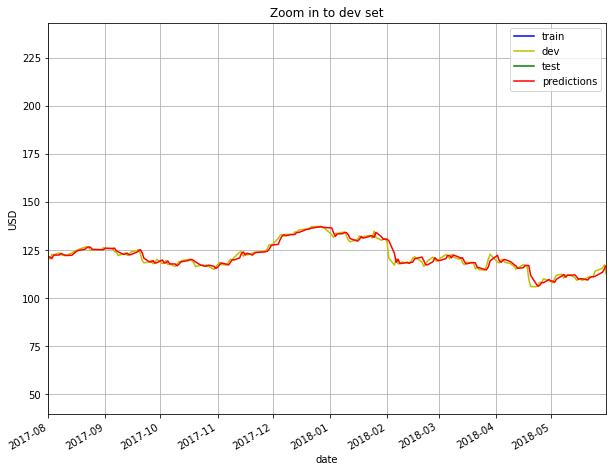

In [162]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")

In [163]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_hl_lag_2', 0.00011280518),
 ('volume_lag_2', 0.000117729745),
 ('range_hl_lag_3', 0.00013699848),
 ('range_hl_lag_1', 0.00014153421),
 ('volume_lag_3', 0.00015166595),
 ('range_oc_lag_3', 0.00015373506),
 ('range_oc_lag_1', 0.00017281236),
 ('adj_close_lag_2', 0.14290866),
 ('adj_close_lag_3', 0.17119607),
 ('adj_close_lag_1', 0.68470764)]

In [164]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


In [165]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-165-5eb9bdbf9a33>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 2.4820128043492633


,n_estimators,max_depth,rmse,mape_pct
0,10,2,1.867324,0.986032
1,10,3,1.909684,1.008151
2,10,4,1.877322,0.989597
3,10,5,1.871517,0.983556
4,10,6,1.871794,0.983765
...,...,...,...,...
235,300,5,1.820960,0.968931
236,300,6,1.819542,0.967174
237,300,7,1.818696,0.965648
238,300,8,1.819295,0.967533


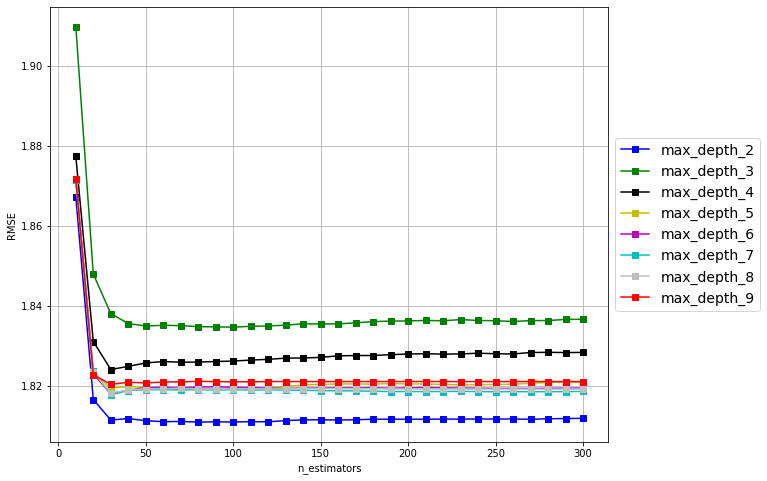

In [166]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [167]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 1.811
optimum params = 


(80, 2)

In [168]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.961%
optimum params = 


(30, 2)

In [169]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-169-2cc15d676f25>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/7 [00:00<?, ?it/s]

Minutes taken = 0.2513403336207072


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,2.226939,1.187155
1,0.001,6,2.226939,1.187155
2,0.001,7,2.226939,1.187155
3,0.001,8,2.226939,1.187155
4,0.001,9,2.226939,1.187155
...,...,...,...,...
107,0.300,16,1.891313,1.013184
108,0.300,17,1.894063,1.015274
109,0.300,18,1.893708,1.014939
110,0.300,19,1.894229,1.014543


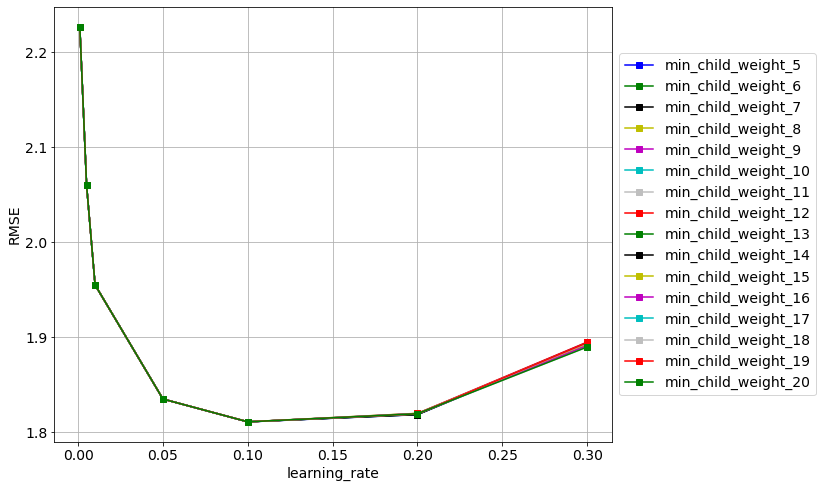

In [170]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [171]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.811
optimum params = 


(0.1, 11)

In [172]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.962%
optimum params = 


(0.1, 14)

In [173]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-173-452a848947be>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.2078919768333435


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,1.854127,0.989735
1,0.1,0.2,1.847801,0.987202
2,0.1,0.3,1.851564,0.988372
3,0.1,0.4,1.839430,0.981792
4,0.1,0.5,1.832260,0.978200
...,...,...,...,...
95,1.0,0.6,1.811967,0.962869
96,1.0,0.7,1.811795,0.962763
97,1.0,0.8,1.812022,0.962814
98,1.0,0.9,1.812238,0.963066


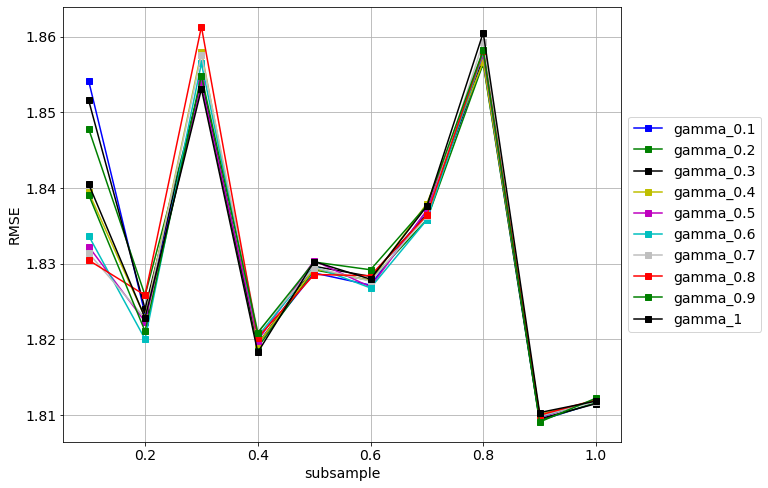

In [174]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [175]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.809
optimum params = 


(0.9, 0.9)

In [176]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.960%
optimum params = 


(0.9, 0.1)

In [177]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-177-4c3379c374e1>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 0.07018127838770548


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,2.347761,1.277918
1,0.5,0.6,2.347761,1.277918
2,0.5,0.7,2.237571,1.221703
3,0.5,0.8,2.237571,1.221703
4,0.5,0.9,2.051447,1.109064
5,0.5,1.0,2.020162,1.093236
6,0.6,0.5,2.230351,1.215016
7,0.6,0.6,2.124067,1.154755
8,0.6,0.7,2.124067,1.154755
9,0.6,0.8,2.070273,1.120254


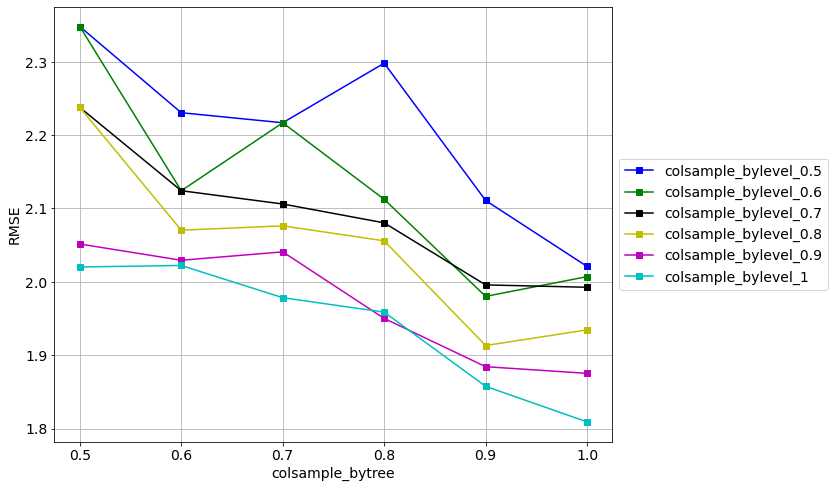

In [178]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [179]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.809
optimum params = 


(1.0, 1.0)

In [180]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.960%
optimum params = 


(1.0, 1.0)

In [181]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,80.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,11.000
4,subsample,1.000,0.900
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.900
8,rmse,1.835,1.809
9,mape_pct,0.976,0.960


In [182]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 3.179
MAPE on test set = 1.102%


Text(0, 0.5, 'USD')

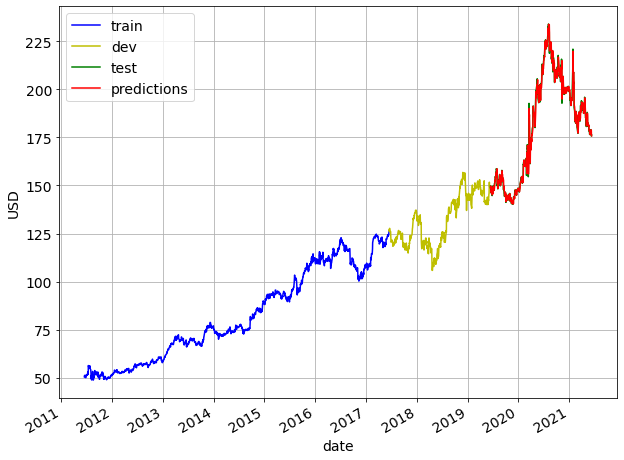

In [183]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

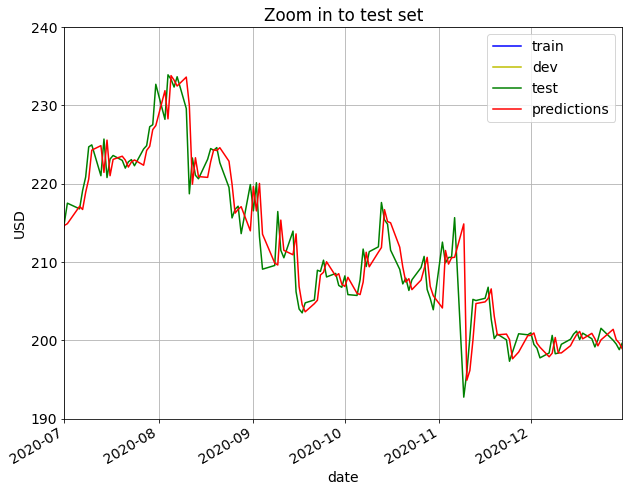

In [184]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 7, 1), date(2020, 12, 31)])
ax.set_ylim([190,240])
ax.set_title("Zoom in to test set")

(190.0, 240.0)

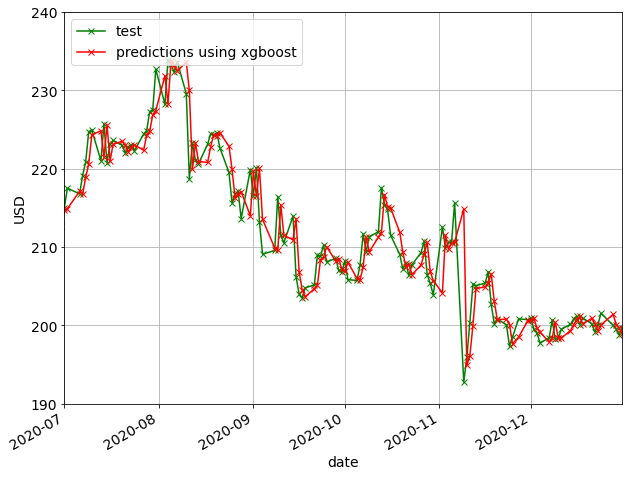

In [185]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 7, 1), date(2020, 12, 31)])
ax.set_ylim([190,240])

In [186]:
# Save as csv
test_xgboost_CLX = est_df
test_xgboost_CLX.to_csv("C:/Users/Parikshit Ghosh/Downloads/ML models/test_xgboost_CLX.csv")